### Conf

In [1]:
INPUT_PATH="/ADNI/ADNI"
CSV_PATH="/ADNI/ADNI1_Complete_1Yr_1.5T_10_13_2019.csv"
OUTPUT_PATH="/ADNI/preprocess_ADNI"

### Logger

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### Pandas

In [3]:
import pandas as pd
import re
import os
df = pd.read_csv(CSV_PATH)

all_files = []
for (dirpath, dirnames, filenames) in os.walk(INPUT_PATH): 
    for f in filenames: 
        if f.endswith("nii"): 
            all_files.append(int(re.split("_|\.", f)[-2][1:]))
all_files = set(all_files)
            
mci_img_ids = set(df.loc[df['Group'] == 'MCI']['Image Data ID'].unique()) & all_files
cn_img_ids = set(df.loc[df['Group'] == 'CN']['Image Data ID'].unique())& all_files
ad_img_ids = set(df.loc[df['Group'] == 'AD']['Image Data ID'].unique()) & all_files

logger.warning(f"MCI images {len(mci_img_ids)}, CN images {len(cn_img_ids)}, AD images {len(ad_img_ids)}")

MCI images 1036, CN images 638, AD images 445


### Imports 

In [1]:
import os
import nipype.interfaces.io as nio
import logging
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nb
from nipype import SelectFiles, Node, Workflow, MapNode, IdentityInterface
from nipype.interfaces.fsl import BET

200301-23:45:33,951 nipype.utils INFO:
	 Running nipype version 1.5.0-dev (latest: 1.4.2)


In [5]:
# Input
infosource = Node(IdentityInterface(fields=['image_id']),
                  name="infosource")
infosource.iterables = [('image_id', cn_img_ids)]

input_node = Node(SelectFiles({'anat':'*_S_*/*/*/S*/*_I{image_id}.nii'}, base_directory=INPUT_PATH), name="input_node")

# Skull stripping Node with BET 
skullstrip = MapNode(BET(mask=True), name="skullstrip", iterfield=['in_file'])
# Sink
sink = Node(interface=nio.DataSink(),name='sink')
sink.inputs.regexp_substitutions = [("_skullstrip[0-9]+", "")]
# Preprocess Workflow
pre_wf = Workflow(name='preproc')
# Connections
pre_wf.connect(infosource, "image_id", input_node, "image_id")
pre_wf.connect(input_node, "anat", skullstrip, "in_file")
pre_wf.connect(skullstrip, "out_file",sink, "@out_file")


200227-07:32:50,755 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/notebooks/graph.png (graph2use=flat, simple_form=True).


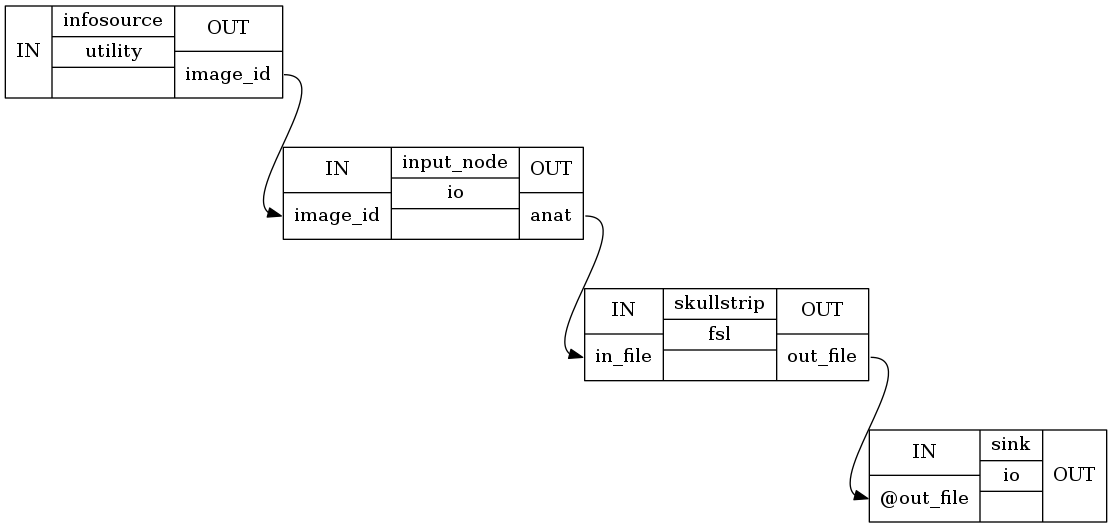

In [6]:
# Create preproc output graph
pre_wf.write_graph(graph2use='flat', format='png', simple_form=True, )
from IPython.display import Image
Image('/home/neuro/notebooks/graph_detailed.png')

In [ ]:
pre_wf.inputs.sink.base_directory = os.path.join(OUTPUT_PATH,"cn")
%time pre_wf.run(plugin='MultiProc', plugin_args={'n_procs' : 8 , 'memory_gb' : 10})

200227-07:32:50,880 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
200227-07:32:55,783 nipype.workflow INFO:
	 Running in parallel.
200227-07:32:55,942 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 638 jobs ready. Free memory (GB): 10.00/10.00, Free processors: 8/8.
200227-07:32:56,5 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmpty1qxfhf/preproc/_image_id_59391/input_node".200227-07:32:56,16 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmpggnkt_px/preproc/_image_id_118772/input_node".200227-07:32:56,11 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmps6ndc6we/preproc/_image_id_118774/input_node".200227-07:32:56,9 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmpya4hez_j/preproc/_image_id_118775/input_node".200227-07:32:56,16 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmpa8amzvvf/preproc/_i

200227-07:33:50,228 nipype.workflow INFO:
	 [Node] Setting-up "preproc.skullstrip" in "/tmp/tmpuswfb68q/preproc/_image_id_42992/skullstrip".200227-07:33:50,221 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmp749lx_5w/preproc/_image_id_118767/sink".200227-07:33:50,231 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmpa0louiqb/preproc/_image_id_59375/input_node".

200227-07:33:50,295 nipype.workflow INFO:
	 [Node] Setting-up "_skullstrip0" in "/tmp/tmpuswfb68q/preproc/_image_id_42992/skullstrip/mapflow/_skullstrip0".
200227-07:33:50,336 nipype.workflow INFO:
	 [Node] Running "_skullstrip0" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /ADNI/ADNI/137_S_0459/MPR__GradWarp__N3__Scaled/2006-11-14_09_22_14.0/S22519/ADNI_137_S_0459_MR_MPR__GradWarp__N3__Scaled_Br_20070306172820274_S22519_I42992.nii /tmp/tmpuswfb68q/preproc/_image_id_42992/skullstrip/mapflow/_skullstrip0/ADNI_137_S_0459_MR_MPR__GradWarp__N3__Sca

	 sub: /ADNI/preprocess_ADNI/cn/_image_id_42992/_skullstrip0/ADNI_137_S_0459_MR_MPR__GradWarp__N3__Scaled_Br_20070306172820274_S22519_I42992_brain.nii.gz -> /ADNI/preprocess_ADNI/cn/_image_id_42992//ADNI_137_S_0459_MR_MPR__GradWarp__N3__Scaled_Br_20070306172820274_S22519_I42992_brain.nii.gz
200227-07:34:20,450 nipype.workflow INFO:
	 [Node] Running "_skullstrip0" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /ADNI/ADNI/094_S_0526/MPR-R__GradWarp__B1_Correction__N3__Scaled/2006-05-16_13_26_28.0/S14559/ADNI_094_S_0526_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20070731182958172_S14559_I63468.nii /tmp/tmp1_sn7jii/preproc/_image_id_63468/skullstrip/mapflow/_skullstrip0/ADNI_094_S_0526_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20070731182958172_S14559_I63468_brain.nii.gz -m
200227-07:34:20,828 nipype.workflow INFO:
	 [Node] Finished "preproc.sink".
200227-07:34:21,976 nipype.workflow INFO:
	 [Job 26] Completed (preproc.sink).
200227-07:34:2

	 sub: /ADNI/preprocess_ADNI/cn/_image_id_63468/_skullstrip0/ADNI_094_S_0526_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20070731182958172_S14559_I63468_brain.nii.gz -> /ADNI/preprocess_ADNI/cn/_image_id_63468//ADNI_094_S_0526_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20070731182958172_S14559_I63468_brain.nii.gz
200227-07:34:55,13 nipype.workflow INFO:
	 [Node] Finished "preproc.sink".
200227-07:34:56,3 nipype.workflow INFO:
	 [Job 38] Completed (preproc.sink).
200227-07:34:56,191 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 618 jobs ready. Free memory (GB): 8.60/10.00, Free processors: 1/8.
                     Currently running:
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.input_node
200227-07:34:56,332 nipype.wo

200227-07:35:14,276 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmp384vmk44/preproc/_image_id_124897/sink".200227-07:35:14,298 nipype.workflow INFO:
	 [Node] Setting-up "preproc.skullstrip" in "/tmp/tmph320w5nr/preproc/_image_id_51165/skullstrip".

200227-07:35:14,317 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
200227-07:35:14,335 nipype.workflow INFO:
	 [Node] Setting-up "_skullstrip0" in "/tmp/tmph320w5nr/preproc/_image_id_51165/skullstrip/mapflow/_skullstrip0".
200227-07:35:14,355 nipype.interface INFO:
	 sub: /ADNI/preprocess_ADNI/cn/_image_id_124897/_skullstrip0/ADNI_041_S_0262_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20081103091239359_S12292_I124897_brain.nii.gz -> /ADNI/preprocess_ADNI/cn/_image_id_124897//ADNI_041_S_0262_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20081103091239359_S12292_I124897_brain.nii.gz
200227-07:35:14,379 nipype.workflow INFO:
	 [Node] Running "_skullstrip0" ("nipype.interfaces.fsl.prepro

200227-07:35:46,304 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmp5q85btxr/preproc/_image_id_96211/input_node".
200227-07:35:46,346 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")
200227-07:35:46,696 nipype.workflow INFO:
	 [Node] Finished "_skullstrip0".
200227-07:35:46,717 nipype.workflow INFO:
	 [Node] Finished "preproc.skullstrip".
200227-07:35:48,39 nipype.workflow INFO:
	 [Job 52] Completed (preproc.skullstrip).
200227-07:35:48,67 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 612 jobs ready. Free memory (GB): 8.60/10.00, Free processors: 1/8.
                     Currently running:
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.skullstrip
200227-07:35:48,

	 [Node] Finished "preproc.input_node".
200227-07:36:02,333 nipype.workflow INFO:
	 [Node] Setting-up "preproc.skullstrip" in "/tmp/tmpur3xg6c5/preproc/_image_id_108504/skullstrip".200227-07:36:02,337 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmp7c8agc0e/preproc/_image_id_65489/input_node".
200227-07:36:02,355 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")

200227-07:36:02,418 nipype.workflow INFO:
	 [Node] Setting-up "_skullstrip0" in "/tmp/tmpur3xg6c5/preproc/_image_id_108504/skullstrip/mapflow/_skullstrip0".
200227-07:36:02,447 nipype.workflow INFO:
	 [Node] Running "_skullstrip0" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /ADNI/ADNI/023_S_0058/MPR__GradWarp__B1_Correction__N3__Scaled/2005-11-30_09_36_10.0/S10335/ADNI_023_S_0058_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080605143248460_S10335_I108504.nii /tmp/tmpur3xg6c5/preproc/_image_id_108504/skullstrip/mapflow/

200227-07:36:42,943 nipype.workflow INFO:
	 [Node] Finished "preproc.input_node".
200227-07:36:43,543 nipype.workflow INFO:
	 [Node] Finished "_skullstrip0".
200227-07:36:43,577 nipype.workflow INFO:
	 [Node] Finished "preproc.skullstrip".
200227-07:36:44,105 nipype.workflow INFO:
	 [Job 90] Completed (preproc.input_node).
200227-07:36:44,119 nipype.workflow INFO:
	 [Job 85] Completed (preproc.skullstrip).
200227-07:36:44,185 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 606 jobs ready. Free memory (GB): 8.80/10.00, Free processors: 2/8.
                     Currently running:
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
200227-07:36:44,457 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmpukgvbwrm/preproc/_image_id_118737/sink".200227-07:36

200227-07:36:52,140 nipype.workflow INFO:
	 [Job 83] Completed (preproc.sink).
200227-07:36:52,184 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 603 jobs ready. Free memory (GB): 8.80/10.00, Free processors: 2/8.
                     Currently running:
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.input_node
200227-07:36:52,305 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmp8_9ngpj6/preproc/_image_id_65489/sink".
200227-07:36:52,315 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmpy7iehklg/preproc/_image_id_63429/input_node".
200227-07:36:52,337 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")
200227-07:36:52,371 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.Data

200227-07:37:18,492 nipype.workflow INFO:
	 [Node] Setting-up "preproc.skullstrip" in "/tmp/tmp9qp558in/preproc/_image_id_63429/skullstrip".200227-07:37:18,499 nipype.workflow INFO:
	 [Node] Setting-up "preproc.skullstrip" in "/tmp/tmp_wkw_qwd/preproc/_image_id_51138/skullstrip".

200227-07:37:18,517 nipype.workflow INFO:
	 [Node] Setting-up "_skullstrip0" in "/tmp/tmp_wkw_qwd/preproc/_image_id_51138/skullstrip/mapflow/_skullstrip0".200227-07:37:18,535 nipype.workflow INFO:
	 [Node] Setting-up "_skullstrip0" in "/tmp/tmp9qp558in/preproc/_image_id_63429/skullstrip/mapflow/_skullstrip0".

200227-07:37:18,605 nipype.workflow INFO:
	 [Node] Running "_skullstrip0" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /ADNI/ADNI/013_S_0502/MPR__GradWarp__B1_Correction__N3__Scaled/2006-07-25_13_35_33.0/S17232/ADNI_013_S_0502_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070426090217227_S17232_I51138.nii /tmp/tmp_wkw_qwd/preproc/_image_id_51138/skullstrip/mapfl

200227-07:37:42,608 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmp86mhhkki/preproc/_image_id_47047/sink".
200227-07:37:42,640 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
200227-07:37:42,686 nipype.interface INFO:
	 sub: /ADNI/preprocess_ADNI/cn/_image_id_47047/_skullstrip0/ADNI_027_S_0403_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20070327115739484_S21484_I47047_brain.nii.gz -> /ADNI/preprocess_ADNI/cn/_image_id_47047//ADNI_027_S_0403_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20070327115739484_S21484_I47047_brain.nii.gz
200227-07:37:43,110 nipype.workflow INFO:
	 [Node] Finished "preproc.sink".
200227-07:37:44,160 nipype.workflow INFO:
	 [Job 104] Completed (preproc.sink).
200227-07:37:44,207 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 597 jobs ready. Free memory (GB): 8.60/10.00, Free processors: 1/8.
                     Currently running:
                       * preproc.input_node
                 

	 [Node] Setting-up "preproc.skullstrip" in "/tmp/tmpvcoovu_d/preproc/_image_id_65464/skullstrip".
200227-07:38:12,492 nipype.interface INFO:
	 sub: /ADNI/preprocess_ADNI/cn/_image_id_67522/_skullstrip0/ADNI_041_S_0125_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070813171700209_S25732_I67522_brain.nii.gz -> /ADNI/preprocess_ADNI/cn/_image_id_67522//ADNI_041_S_0125_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070813171700209_S25732_I67522_brain.nii.gz200227-07:38:12,498 nipype.workflow INFO:
	 [Node] Setting-up "preproc.skullstrip" in "/tmp/tmpw20d0jeu/preproc/_image_id_118711/skullstrip".200227-07:38:12,500 nipype.workflow INFO:
	 [Node] Setting-up "_skullstrip0" in "/tmp/tmpvcoovu_d/preproc/_image_id_65464/skullstrip/mapflow/_skullstrip0".


200227-07:38:12,545 nipype.workflow INFO:
	 [Node] Running "_skullstrip0" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /ADNI/ADNI/099_S_0534/MPR-R__GradWarp__B1_Correction__N3__Scaled/2007-05-23_13_0

200227-07:38:37,746 nipype.workflow INFO:
	 [Node] Finished "_skullstrip0".
200227-07:38:37,777 nipype.workflow INFO:
	 [Node] Finished "preproc.skullstrip".
200227-07:38:38,208 nipype.workflow INFO:
	 [Job 127] Completed (preproc.skullstrip).
200227-07:38:38,241 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 591 jobs ready. Free memory (GB): 8.60/10.00, Free processors: 1/8.
                     Currently running:
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.skullstrip
200227-07:38:38,421 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmpharf18mp/preproc/_image_id_65464/sink".
200227-07:38:38,474 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
200227-07:38:38,522 nipype.interfa

200227-07:38:50,259 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 588 jobs ready. Free memory (GB): 8.60/10.00, Free processors: 1/8.
                     Currently running:
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.skullstrip
200227-07:38:50,525 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmphgugms80/preproc/_image_id_118701/input_node".
200227-07:38:50,577 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")
200227-07:38:52,337 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 587 jobs ready. Free memory (GB): 8.40/10.00, Free processors: 0/8.
                     Currently running:
                       * preproc.input_node
                       * pr

	 [Node] Setting-up "_skullstrip0" in "/tmp/tmpohktf2zj/preproc/_image_id_118702/skullstrip/mapflow/_skullstrip0".
200227-07:39:12,701 nipype.workflow INFO:
	 [Node] Running "_skullstrip0" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /ADNI/ADNI/010_S_0472/MPR____N3__Scaled_2/2006-11-22_11_30_27.0/S22912/ADNI_010_S_0472_MR_MPR____N3__Scaled_2_Br_20081001121947466_S22912_I118702.nii /tmp/tmpohktf2zj/preproc/_image_id_118702/skullstrip/mapflow/_skullstrip0/ADNI_010_S_0472_MR_MPR____N3__Scaled_2_Br_20081001121947466_S22912_I118702_brain.nii.gz -m
200227-07:39:14,248 nipype.workflow INFO:
	 [Job 136] Completed (preproc.skullstrip).
200227-07:39:14,266 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 586 jobs ready. Free memory (GB): 8.60/10.00, Free processors: 1/8.
                     Currently running:
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
         

	 [Node] Setting-up "_skullstrip0" in "/tmp/tmpof4afoir/preproc/_image_id_118699/skullstrip/mapflow/_skullstrip0".
200227-07:39:28,740 nipype.workflow INFO:
	 [Node] Running "_skullstrip0" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /ADNI/ADNI/007_S_0068/MPR__GradWarp__B1_Correction__N3__Scaled_2/2006-06-20_10_37_15.0/S15714/ADNI_007_S_0068_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001121650618_S15714_I118699.nii /tmp/tmpof4afoir/preproc/_image_id_118699/skullstrip/mapflow/_skullstrip0/ADNI_007_S_0068_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001121650618_S15714_I118699_brain.nii.gz -m
200227-07:39:30,153 nipype.workflow INFO:
	 [Node] Finished "_skullstrip0".
200227-07:39:30,234 nipype.workflow INFO:
	 [Node] Finished "preproc.skullstrip".
200227-07:39:30,302 nipype.workflow INFO:
	 [Job 139] Completed (preproc.skullstrip).
200227-07:39:30,336 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 584 jobs ready. Free m

200227-07:39:50,701 nipype.workflow INFO:
	 [Node] Finished "preproc.input_node".200227-07:39:50,713 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmptvlokchi/preproc/_image_id_118702/sink".

200227-07:39:50,736 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
200227-07:39:50,764 nipype.interface INFO:
	 sub: /ADNI/preprocess_ADNI/cn/_image_id_118702/_skullstrip0/ADNI_010_S_0472_MR_MPR____N3__Scaled_2_Br_20081001121947466_S22912_I118702_brain.nii.gz -> /ADNI/preprocess_ADNI/cn/_image_id_118702//ADNI_010_S_0472_MR_MPR____N3__Scaled_2_Br_20081001121947466_S22912_I118702_brain.nii.gz
200227-07:39:51,305 nipype.workflow INFO:
	 [Node] Finished "preproc.sink".
200227-07:39:52,286 nipype.workflow INFO:
	 [Job 162] Completed (preproc.input_node).
200227-07:39:52,306 nipype.workflow INFO:
	 [Job 149] Completed (preproc.sink).
200227-07:39:52,341 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 583 jobs ready. Free memory (GB): 8.80/10.

	 [Node] Setting-up "preproc.skullstrip" in "/tmp/tmpfaccc6qh/preproc/_image_id_71588/skullstrip".

200227-07:40:20,516 nipype.workflow INFO:
	 [Node] Setting-up "_skullstrip0" in "/tmp/tmpfaccc6qh/preproc/_image_id_71588/skullstrip/mapflow/_skullstrip0".
200227-07:40:20,531 nipype.workflow INFO:
	 [Node] Running "_skullstrip0" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /ADNI/ADNI/037_S_0454/MPR-R__GradWarp__N3__Scaled/2007-06-13_10_56_12.0/S33516/ADNI_037_S_0454_MR_MPR-R__GradWarp__N3__Scaled_Br_20070904205517589_S33516_I71588.nii /tmp/tmpfaccc6qh/preproc/_image_id_71588/skullstrip/mapflow/_skullstrip0/ADNI_037_S_0454_MR_MPR-R__GradWarp__N3__Scaled_Br_20070904205517589_S33516_I71588_brain.nii.gz -m
200227-07:40:20,703 nipype.workflow INFO:
	 [Node] Finished "preproc.sink".
200227-07:40:20,763 nipype.workflow INFO:
	 [Node] Finished "preproc.sink".
200227-07:40:22,315 nipype.workflow INFO:
	 [Job 164] Completed (preproc.sink).
200227-07:40:22,32

200227-07:40:40,368 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 575 jobs ready. Free memory (GB): 8.60/10.00, Free processors: 1/8.
                     Currently running:
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.input_node
200227-07:40:40,611 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmp18w8mth7/preproc/_image_id_71588/sink".
200227-07:40:40,649 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
200227-07:40:40,669 nipype.interface INFO:
	 sub: /ADNI/preprocess_ADNI/cn/_image_id_71588/_skullstrip0/ADNI_037_S_0454_MR_MPR-R__GradWarp__N3__Scaled_Br_20070904205517589_S33516_I71588_brain.nii.gz -> /ADNI/preprocess_ADNI/cn/_image_id_71588//ADNI_037_S_0454_MR_MPR-R__GradWarp

	 [Node] Setting-up "preproc.input_node" in "/tmp/tmpbvw2d5yi/preproc/_image_id_118673/input_node".
200227-07:41:18,684 nipype.workflow INFO:
	 [Node] Setting-up "_skullstrip0" in "/tmp/tmpxvg2v1sn/preproc/_image_id_118677/skullstrip/mapflow/_skullstrip0".200227-07:41:18,701 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")

200227-07:41:18,736 nipype.workflow INFO:
	 [Node] Running "_skullstrip0" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /ADNI/ADNI/007_S_0068/MPR-R__GradWarp__B1_Correction__N3__Scaled_2/2005-11-30_11_37_19.0/S10356/ADNI_007_S_0068_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001115126961_S10356_I118677.nii /tmp/tmpxvg2v1sn/preproc/_image_id_118677/skullstrip/mapflow/_skullstrip0/ADNI_007_S_0068_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001115126961_S10356_I118677_brain.nii.gz -m
200227-07:41:19,276 nipype.workflow INFO:
	 [Node] Finished "_skullstrip0".
200227-07:

200227-07:41:36,634 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmpcpqieqa0/preproc/_image_id_83849/input_node".
200227-07:41:36,659 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")
200227-07:41:38,35 nipype.workflow INFO:
	 [Node] Finished "preproc.input_node".
200227-07:41:38,386 nipype.workflow INFO:
	 [Job 201] Completed (preproc.input_node).
200227-07:41:38,421 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 567 jobs ready. Free memory (GB): 8.60/10.00, Free processors: 1/8.
                     Currently running:
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
200227-07:41:38,714 nipype.workflow INFO:
	 [Node] Setting-up "preproc.skullstrip" in "/tm

	 [Node] Setting-up "_skullstrip0" in "/tmp/tmpp2_x3_4a/preproc/_image_id_75651/skullstrip/mapflow/_skullstrip0".
200227-07:42:10,725 nipype.workflow INFO:
	 [Node] Running "_skullstrip0" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /ADNI/ADNI/094_S_0711/MPR__GradWarp__B1_Correction__N3__Scaled/2007-08-23_13_24_52.0/S38424/ADNI_094_S_0711_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070927172520148_S38424_I75651.nii /tmp/tmpp2_x3_4a/preproc/_image_id_75651/skullstrip/mapflow/_skullstrip0/ADNI_094_S_0711_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070927172520148_S38424_I75651_brain.nii.gz -m
200227-07:42:12,464 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 562 jobs ready. Free memory (GB): 8.40/10.00, Free processors: 0/8.
                     Currently running:
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.sku

200227-07:42:35,409 nipype.workflow INFO:
	 [Node] Finished "preproc.input_node".
200227-07:42:36,489 nipype.workflow INFO:
	 [Job 225] Completed (preproc.input_node).
200227-07:42:36,535 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 561 jobs ready. Free memory (GB): 8.60/10.00, Free processors: 1/8.
                     Currently running:
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.skullstrip
200227-07:42:36,732 nipype.workflow INFO:
	 [Node] Setting-up "preproc.skullstrip" in "/tmp/tmpx9045_ep/preproc/_image_id_79742/skullstrip".
200227-07:42:36,776 nipype.workflow INFO:
	 [Node] Setting-up "_skullstrip0" in "/tmp/tmpx9045_ep/preproc/_image_id_79742/skullstrip/mapflow/_skullstrip0".
200227-07:42:36,809 nipype.workflow INFO:


	 [Node] Setting-up "_skullstrip0" in "/tmp/tmp0len2_1e/preproc/_image_id_96110/skullstrip/mapflow/_skullstrip0".
200227-07:42:54,812 nipype.workflow INFO:
	 [Node] Running "_skullstrip0" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /ADNI/ADNI/022_S_0066/MPR__GradWarp__B1_Correction__N3__Scaled/2006-12-18_09_22_57.0/S45826/ADNI_022_S_0066_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080307182205131_S45826_I96110.nii /tmp/tmp0len2_1e/preproc/_image_id_96110/skullstrip/mapflow/_skullstrip0/ADNI_022_S_0066_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080307182205131_S45826_I96110_brain.nii.gz -m
200227-07:42:56,563 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 558 jobs ready. Free memory (GB): 8.40/10.00, Free processors: 0/8.
                     Currently running:
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.sku

200227-07:43:34,657 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmp7pddqfil/preproc/_image_id_42832/input_node".
200227-07:43:34,676 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")
200227-07:43:34,733 nipype.workflow INFO:
	 [Node] Finished "_skullstrip0".
200227-07:43:34,764 nipype.workflow INFO:
	 [Node] Finished "preproc.skullstrip".
200227-07:43:36,503 nipype.workflow INFO:
	 [Job 235] Completed (preproc.skullstrip).
200227-07:43:36,540 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 552 jobs ready. Free memory (GB): 8.60/10.00, Free processors: 1/8.
                     Currently running:
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.input_node
200227-07:43:

200227-07:43:46,904 nipype.workflow INFO:
	 [Node] Setting-up "preproc.skullstrip" in "/tmp/tmphynzy7aq/preproc/_image_id_59224/skullstrip".
200227-07:43:46,943 nipype.workflow INFO:
	 [Node] Setting-up "_skullstrip0" in "/tmp/tmphynzy7aq/preproc/_image_id_59224/skullstrip/mapflow/_skullstrip0".
200227-07:43:46,970 nipype.workflow INFO:
	 [Node] Running "_skullstrip0" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /ADNI/ADNI/012_S_1133/MPR____N3__Scaled/2007-01-12_11_21_49.0/S25016/ADNI_012_S_1133_MR_MPR____N3__Scaled_Br_20070711170922052_S25016_I59224.nii /tmp/tmphynzy7aq/preproc/_image_id_59224/skullstrip/mapflow/_skullstrip0/ADNI_012_S_1133_MR_MPR____N3__Scaled_Br_20070711170922052_S25016_I59224_brain.nii.gz -m
200227-07:43:48,562 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 550 jobs ready. Free memory (GB): 8.40/10.00, Free processors: 0/8.
                     Currently running:
                       * preproc.skullstrip
          

	 sub: /ADNI/preprocess_ADNI/cn/_image_id_51034/_skullstrip0/ADNI_133_S_0525_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070425175627188_S26013_I51034_brain.nii.gz -> /ADNI/preprocess_ADNI/cn/_image_id_51034//ADNI_133_S_0525_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070425175627188_S26013_I51034_brain.nii.gz
200227-07:44:31,608 nipype.workflow INFO:
	 [Node] Finished "preproc.sink".
200227-07:44:31,675 nipype.workflow INFO:
	 [Node] Finished "preproc.sink".
200227-07:44:32,287 nipype.workflow INFO:
	 [Node] Finished "_skullstrip0".
200227-07:44:32,326 nipype.workflow INFO:
	 [Node] Finished "preproc.skullstrip".
200227-07:44:32,561 nipype.workflow INFO:
	 [Job 262] Completed (preproc.skullstrip).
200227-07:44:32,570 nipype.workflow INFO:
	 [Job 248] Completed (preproc.sink).
200227-07:44:32,577 nipype.workflow INFO:
	 [Job 251] Completed (preproc.sink).
200227-07:44:32,631 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 548 jobs ready. Free memory (GB): 9.00/10.00,

	 [Node] Setting-up "preproc.skullstrip" in "/tmp/tmpydld908k/preproc/_image_id_108336/skullstrip".200227-07:45:00,904 nipype.interface INFO:
	 sub: /ADNI/preprocess_ADNI/cn/_image_id_89910/_skullstrip0/ADNI_128_S_0863_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080207171412302_S41651_I89910_brain.nii.gz -> /ADNI/preprocess_ADNI/cn/_image_id_89910//ADNI_128_S_0863_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080207171412302_S41651_I89910_brain.nii.gz

200227-07:45:00,947 nipype.workflow INFO:
	 [Node] Setting-up "_skullstrip0" in "/tmp/tmpydld908k/preproc/_image_id_108336/skullstrip/mapflow/_skullstrip0".
200227-07:45:00,991 nipype.workflow INFO:
	 [Node] Running "_skullstrip0" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /ADNI/ADNI/941_S_1197/MPR__GradWarp__B1_Correction__N3__Scaled/2008-05-21_16_08_35.0/S50683/ADNI_941_S_1197_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080604081641800_S50683_I108336.nii /tmp/tmpydld908k/preproc/_im

	 [Node] Setting-up "preproc.skullstrip" in "/tmp/tmp4t6vzbsx/preproc/_image_id_59169/skullstrip".200227-07:45:38,941 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmpwqbc0kzs/preproc/_image_id_96025/input_node".
200227-07:45:38,961 nipype.workflow INFO:
	 [Node] Setting-up "_skullstrip0" in "/tmp/tmp4t6vzbsx/preproc/_image_id_59169/skullstrip/mapflow/_skullstrip0".

200227-07:45:38,998 nipype.workflow INFO:
	 [Node] Running "_skullstrip0" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /ADNI/ADNI/012_S_0637/MPR____N3__Scaled/2007-01-08_08_21_33.0/S24836/ADNI_012_S_0637_MR_MPR____N3__Scaled_Br_20070711163916979_S24836_I59169.nii /tmp/tmp4t6vzbsx/preproc/_image_id_59169/skullstrip/mapflow/_skullstrip0/ADNI_012_S_0637_MR_MPR____N3__Scaled_Br_20070711163916979_S24836_I59169_brain.nii.gz -m
200227-07:45:39,1 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")
200227-07:45:40,694 nipype.workfl

200227-07:46:03,8 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmpy_k63uun/preproc/_image_id_36628/input_node".200227-07:46:03,16 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmp88yqt2yf/preproc/_image_id_42772/input_node".

200227-07:46:03,59 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")
200227-07:46:03,74 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")
200227-07:46:04,732 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 534 jobs ready. Free memory (GB): 8.40/10.00, Free processors: 0/8.
                     Currently running:
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
            

200227-07:46:25,327 nipype.workflow INFO:
	 [Node] Finished "_skullstrip0".
200227-07:46:25,377 nipype.workflow INFO:
	 [Node] Finished "preproc.skullstrip".
200227-07:46:26,654 nipype.workflow INFO:
	 [Job 295] Completed (preproc.skullstrip).
200227-07:46:26,689 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 533 jobs ready. Free memory (GB): 8.60/10.00, Free processors: 1/8.
                     Currently running:
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.skullstrip
200227-07:46:26,952 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmp3m2osfj3/preproc/_image_id_59169/sink".
200227-07:46:27,6 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
200227-07:46:27,24 nipype.interface 

200227-07:47:05,891 nipype.workflow INFO:
	 [Node] Finished "_skullstrip0".
200227-07:47:05,907 nipype.workflow INFO:
	 [Node] Finished "preproc.skullstrip".
200227-07:47:06,691 nipype.workflow INFO:
	 [Job 307] Completed (preproc.skullstrip).
200227-07:47:06,761 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 529 jobs ready. Free memory (GB): 8.60/10.00, Free processors: 1/8.
                     Currently running:
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
200227-07:47:07,0 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmpvxwwjdgf/preproc/_image_id_36628/sink".
200227-07:47:07,82 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
200227-07:47:07,123 nipype.interface 

200227-07:47:17,19 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmpnduhvv_v/preproc/_image_id_91851/input_node".
200227-07:47:17,51 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")
200227-07:47:18,820 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 525 jobs ready. Free memory (GB): 8.40/10.00, Free processors: 0/8.
                     Currently running:
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.skullstrip
200227-07:47:22,42 nipype.workflow INFO:
	 [Node] Finished "_skullstrip0".
200227-07:47:22,66 nipype.workflow INFO:
	 [Node] Finished "preproc.skullstrip".
200227-07:47:22,648 nipype.workflow INFO:
	 [Node] Finished

	 [Node] Setting-up "preproc.input_node" in "/tmp/tmp1jctqjxn/preproc/_image_id_89796/input_node".
200227-07:47:55,100 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")
200227-07:47:56,800 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 521 jobs ready. Free memory (GB): 8.40/10.00, Free processors: 0/8.
                     Currently running:
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.skullstrip
200227-07:48:05,392 nipype.workflow INFO:
	 [Node] Finished "preproc.input_node".
200227-07:48:06,754 nipype.workflow INFO:
	 [Job 342] Completed (preproc.input_node).
200227-07:48:06,799 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 522 jobs r

200227-07:48:19,33 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmpo0fpuera/preproc/_image_id_71348/input_node".
200227-07:48:19,75 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")
200227-07:48:20,327 nipype.workflow INFO:
	 [Node] Finished "_skullstrip0".
200227-07:48:20,367 nipype.workflow INFO:
	 [Node] Finished "preproc.skullstrip".
200227-07:48:20,766 nipype.workflow INFO:
	 [Job 334] Completed (preproc.skullstrip).
200227-07:48:20,810 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 520 jobs ready. Free memory (GB): 8.60/10.00, Free processors: 1/8.
                     Currently running:
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
200227-07:48:21

200227-07:48:32,912 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmpp3g9seg_/preproc/_image_id_71402/sink".200227-07:48:32,916 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmpob5d8e_o/preproc/_image_id_65220/sink".200227-07:48:32,923 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmprjtra2zw/preproc/_image_id_85668/input_node".


200227-07:48:32,951 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
200227-07:48:32,963 nipype.interface INFO:
	 sub: /ADNI/preprocess_ADNI/cn/_image_id_71402/_skullstrip0/ADNI_014_S_0519_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070904184725248_S32599_I71402_brain.nii.gz -> /ADNI/preprocess_ADNI/cn/_image_id_71402//ADNI_014_S_0519_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070904184725248_S32599_I71402_brain.nii.gz200227-07:48:32,957 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")200227-07:48:32,966 nipype.wo

200227-07:48:44,931 nipype.workflow INFO:
	 [Node] Setting-up "preproc.skullstrip" in "/tmp/tmpcsffkynr/preproc/_image_id_63155/skullstrip".
200227-07:48:44,989 nipype.workflow INFO:
	 [Node] Setting-up "_skullstrip0" in "/tmp/tmpcsffkynr/preproc/_image_id_63155/skullstrip/mapflow/_skullstrip0".
200227-07:48:45,28 nipype.workflow INFO:
	 [Node] Running "_skullstrip0" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /ADNI/ADNI/082_S_1256/MPR__GradWarp__B1_Correction__N3__Scaled/2007-02-16_15_10_42.0/S26812/ADNI_082_S_1256_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070731114338839_S26812_I63155.nii /tmp/tmpcsffkynr/preproc/_image_id_63155/skullstrip/mapflow/_skullstrip0/ADNI_082_S_1256_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070731114338839_S26812_I63155_brain.nii.gz -m
200227-07:48:46,894 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 513 jobs ready. Free memory (GB): 8.40/10.00, Free processors: 0/8.
                     Curre

	 [Node] Setting-up "preproc.input_node" in "/tmp/tmpe45jq45c/preproc/_image_id_75401/input_node".
200227-07:49:15,125 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")
200227-07:49:16,896 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 510 jobs ready. Free memory (GB): 8.40/10.00, Free processors: 0/8.
                     Currently running:
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
200227-07:49:25,158 nipype.workflow INFO:
	 [Node] Finished "preproc.input_node".
200227-07:49:26,843 nipype.workflow INFO:
	 [Job 375] Completed (preproc.input_node).
200227-07:49:26,904 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 511 jobs r

	 [Node] Setting-up "preproc.sink" in "/tmp/tmp1ap3q4w2/preproc/_image_id_138890/sink".200227-07:49:57,9 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmpfgx7okf9/preproc/_image_id_91766/input_node".

200227-07:49:57,28 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")
200227-07:49:57,64 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
200227-07:49:57,99 nipype.interface INFO:
	 sub: /ADNI/preprocess_ADNI/cn/_image_id_138890/_skullstrip0/ADNI_002_S_1280_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20090313142921949_S47412_I138890_brain.nii.gz -> /ADNI/preprocess_ADNI/cn/_image_id_138890//ADNI_002_S_1280_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20090313142921949_S47412_I138890_brain.nii.gz
200227-07:49:57,446 nipype.workflow INFO:
	 [Node] Finished "preproc.sink".
200227-07:49:58,875 nipype.workflow INFO:
	 [Job 377] Completed (preproc.sink).
200227-07:49:58,904 nipype.workflow INFO:


	 sub: /ADNI/preprocess_ADNI/cn/_image_id_75394/_skullstrip0/ADNI_009_S_0751_MR_MPR__GradWarp__N3__Scaled_Br_20070926180344105_S26993_I75394_brain.nii.gz -> /ADNI/preprocess_ADNI/cn/_image_id_75394//ADNI_009_S_0751_MR_MPR__GradWarp__N3__Scaled_Br_20070926180344105_S26993_I75394_brain.nii.gz200227-07:50:33,288 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")


200227-07:50:33,324 nipype.interface INFO:
	 sub: /ADNI/preprocess_ADNI/cn/_image_id_65148/_skullstrip0/ADNI_037_S_0303_MR_MPR-R__GradWarp__N3__Scaled_Br_20070806153911498_S12982_I65148_brain.nii.gz -> /ADNI/preprocess_ADNI/cn/_image_id_65148//ADNI_037_S_0303_MR_MPR-R__GradWarp__N3__Scaled_Br_20070806153911498_S12982_I65148_brain.nii.gz200227-07:50:33,321 nipype.interface INFO:
	 sub: /ADNI/preprocess_ADNI/cn/_image_id_36485/_skullstrip0/ADNI_018_S_0043_MR_MPR____N3__Scaled_Br_20070118005318572_S10493_I36485_brain.nii.gz -> /ADNI/preprocess_ADNI/cn/_image_id_36485//ADNI_018_S_0043_MR_MPR____N3__Scale

	 [Node] Finished "_skullstrip0".
200227-07:50:54,422 nipype.workflow INFO:
	 [Node] Finished "preproc.skullstrip".
200227-07:50:54,928 nipype.workflow INFO:
	 [Job 400] Completed (preproc.skullstrip).
200227-07:50:54,936 nipype.workflow INFO:
	 [Job 403] Completed (preproc.skullstrip).
200227-07:50:54,946 nipype.workflow INFO:
	 [Job 407] Completed (preproc.sink).
200227-07:50:54,967 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 499 jobs ready. Free memory (GB): 9.00/10.00, Free processors: 3/8.
                     Currently running:
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.input_node
200227-07:50:55,70 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmpk_lrposn/preproc/_image_id_91766/sink".200227-07:50:55,77 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmp5ikyswo8/pre

200227-07:51:11,25 nipype.workflow INFO:
	 [Node] Finished "preproc.input_node".
200227-07:51:12,947 nipype.workflow INFO:
	 [Job 420] Completed (preproc.input_node).
200227-07:51:12,966 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 495 jobs ready. Free memory (GB): 8.60/10.00, Free processors: 1/8.
                     Currently running:
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.input_node
200227-07:51:13,137 nipype.workflow INFO:
	 [Node] Setting-up "preproc.skullstrip" in "/tmp/tmpuinsdg8u/preproc/_image_id_65082/skullstrip".
200227-07:51:13,192 nipype.workflow INFO:
	 [Node] Setting-up "_skullstrip0" in "/tmp/tmpuinsdg8u/preproc/_image_id_65082/skullstrip/mapflow/_skullstrip0".
200227-07:51:13,226 nipype.workflow INFO:
	

	 [Node] Finished "preproc.input_node".
200227-07:51:44,973 nipype.workflow INFO:
	 [Job 418] Completed (preproc.skullstrip).
200227-07:51:44,985 nipype.workflow INFO:
	 [Job 432] Completed (preproc.input_node).
200227-07:51:44,996 nipype.workflow INFO:
	 [Job 427] Completed (preproc.skullstrip).
200227-07:51:45,22 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 492 jobs ready. Free memory (GB): 9.00/10.00, Free processors: 3/8.
                     Currently running:
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.input_node
                       * preproc.skullstrip
200227-07:51:45,110 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmpdx45c21s/preproc/_image_id_67133/sink".200227-07:51:45,117 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmpeyucx2vi/preproc/_image_id_83503/sink".

200227-07:51:45,140 nipype.workflow INFO

	 sub: /ADNI/preprocess_ADNI/cn/_image_id_52776/_skullstrip0/ADNI_003_S_0981_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20070501171453195_S20753_I52776_brain.nii.gz -> /ADNI/preprocess_ADNI/cn/_image_id_52776//ADNI_003_S_0981_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20070501171453195_S20753_I52776_brain.nii.gz
200227-07:52:11,489 nipype.workflow INFO:
	 [Node] Finished "preproc.sink".
200227-07:52:12,747 nipype.workflow INFO:
	 [Node] Finished "preproc.input_node".200227-07:52:12,750 nipype.workflow INFO:
	 [Node] Finished "preproc.input_node".

200227-07:52:13,46 nipype.workflow INFO:
	 [Job 447] Completed (preproc.input_node).
200227-07:52:13,83 nipype.workflow INFO:
	 [Job 450] Completed (preproc.input_node).
200227-07:52:13,90 nipype.workflow INFO:
	 [Job 437] Completed (preproc.sink).
200227-07:52:13,148 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 487 jobs ready. Free memory (GB): 9.00/10.00, Free processors: 3/8.
                     Currently running:


200227-07:52:33,372 nipype.workflow INFO:
	 [Node] Setting-up "preproc.input_node" in "/tmp/tmpecct7s83/preproc/_image_id_81405/input_node".
200227-07:52:33,405 nipype.workflow INFO:
	 [Node] Running "input_node" ("nipype.interfaces.io.SelectFiles")
200227-07:52:35,134 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 483 jobs ready. Free memory (GB): 8.40/10.00, Free processors: 0/8.
                     Currently running:
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.input_node
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.skullstrip
                       * preproc.skullstrip
200227-07:52:38,257 nipype.workflow INFO:
	 [Node] Finished "_skullstrip0".
200227-07:52:38,276 nipype.workflow INFO:
	 [Node] Finished "preproc.skullstrip".
200227-07:52:39,21 nipype.workflow INFO:
	 [Job 448] Co

200227-07:53:03,187 nipype.workflow INFO:
	 [Node] Setting-up "preproc.sink" in "/tmp/tmpqnpiihpe/preproc/_image_id_42509/sink".
200227-07:53:03,217 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
200227-07:53:03,232 nipype.interface INFO:
	 sub: /ADNI/preprocess_ADNI/cn/_image_id_42509/_skullstrip0/ADNI_033_S_0923_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070304125438114_S19544_I42509_brain.nii.gz -> /ADNI/preprocess_ADNI/cn/_image_id_42509//ADNI_033_S_0923_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070304125438114_S19544_I42509_brain.nii.gz
200227-07:53:03,698 nipype.workflow INFO:
	 [Node] Finished "preproc.sink".
200227-07:53:04,754 nipype.workflow INFO:
	 [Node] Finished "preproc.input_node".
200227-07:53:05,50 nipype.workflow INFO:
	 [Job 465] Completed (preproc.input_node).
200227-07:53:05,60 nipype.workflow INFO:
	 [Job 458] Completed (preproc.sink).
200227-07:53:05,90 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 478 jobs

In [ ]:
from os.path import join as opj

anat_file = opj('sub-{subject_id}', 'ses-test', 'anat', 'sub-{subject_id}_ses-test_T1w.nii.gz')

In [ ]:
anat_file